## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


In [7]:
# Your code here - remember to use markdown cells for comments as well!
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import requests
import json
import time
import random
from bs4 import BeautifulSoup
from tqdm import tqdm
from datetime import datetime as dt
register_matplotlib_converters()
import oos

# The Movie Database API

<b>Pulling Data into Python<b>

In [9]:
apiKey = oos.apiKey
path = oos.path

In [2]:
url = f'https://api.themoviedb.org/3/discover/movie?api_key={apiKey}'
ids=[]
for i in tqdm(range(1,501)):
    params = {'page': i,
              'sort_by':'revenue.desc',
             }
    
    response = requests.get(url, params=params)
    movie = response.text
    movies = json.loads(movie)
    ids.extend([movies['results'][index]['id'] for index in range(len(movies['results']))])
#     time.sleep(random.choice([t/10 for t in range(4,10)]))


100%|██████████| 500/500 [01:23<00:00,  5.98it/s]


In [3]:
movies_info = []
for _id in tqdm(ids):
    url = f'https://api.themoviedb.org/3/movie/{_id}?api_key={apiKey}'
    response = requests.get(url)
    movies_info.append(response.json())
#     time.sleep(random.choice([t/10 for t in range(4,10)]))

100%|██████████| 10000/10000 [16:57<00:00,  9.82it/s]


In [4]:
movies_df = pd.DataFrame.from_dict(movies_info)

<b>Data Cleaning<b>

In [5]:
movies_df.drop(columns = ['adult', 'backdrop_path', 'belongs_to_collection', 'homepage', 'id', 'imdb_id', 'overview',
                          'poster_path', 'success', 'status_code', 'status_message', 'tagline', 'video','vote_average', 'vote_count'], inplace = True)


In [6]:
movies_df.dropna(inplace=True)
for col in movies_df.columns:
    movies_df.isna().sum()

In [9]:
movies_df.to_csv('tmdb_movies.csv')

In [10]:
tmdb_movies = pd.read_csv(path + 'tmdb_movies.csv')

In [11]:
tmdb_movies.head(1)

,Unnamed: 0,budget,genres,original_language,original_title,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title
0,0,356000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 878, ...",en,Avengers: Endgame,194.835,"[{'id': 420, 'logo_path': '/hUzeosd33nzE5MCNsZ...","[{'iso_3166_1': 'US', 'name': 'United States o...",2019-04-24,2.797801e+09,181.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Avengers: Endgame


In [14]:
tmdb_movies.genres = tmdb_movies.genres.map(lambda x : [i['name'] for i in eval(x)])
tmdb_movies.production_companies = tmdb_movies.production_companies.map(lambda x : [i['name'] for i in eval(x)])
tmdb_movies.production_countries = tmdb_movies.production_countries.map(lambda x : [i['name'] for i in eval(x)])
tmdb_movies.spoken_languages = tmdb_movies.spoken_languages.map(lambda x : [i['name'] for i in eval(x)])
tmdb_movies.revenue = tmdb_movies.revenue.map(lambda x: int(x))

In [15]:
tmdb_movies.head(2)

,Unnamed: 0,budget,genres,original_language,original_title,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title
0,0,356000000.0,"[Adventure, Science Fiction, Action]",en,Avengers: Endgame,194.835,[Marvel Studios],[United States of America],2019-04-24,2797800564,181.0,"[English, 日本語, ]",Released,Avengers: Endgame
1,1,237000000.0,"[Action, Adventure, Fantasy, Science Fiction]",en,Avatar,83.189,"[Dune Entertainment, Lightstorm Entertainment,...","[United States of America, United Kingdom]",2009-12-10,2787965087,162.0,"[English, Español]",Released,Avatar


# Web Scraping Rotten Tomatoes

<b> Pulling and Cleaning Data <b>

In [29]:
def get_movie_info_vals(soup):
    return [
        soup.find('h1', class_="mop-ratings-wrap__title mop-ratings-wrap__title--top").getText()
    ] + [','.join(movie_info_val.find('div').next_sibling.next_sibling.get_text().strip().split(
        ", \n                        \n                        "
    )) for movie_info_val in movie_info_lst] + [url] # <---Clean second div of list and return as values

In [30]:
def get_movie_info_cols(soup):
    return ['Title:'] + [','.join(movie_info_col.find('div').get_text().strip().split(
            ", \n                        \n                        "
        )) for movie_info_col in movie_info_lst] + ['url']# <---Clean first div of list and return as columns

In [31]:
# Set headers
headers = {
    'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/53.0.2785.143 Safari/537.36'}

# Get urls
urls = pd.read_csv(path + 'rotten_yrs.csv')['url']

# Create rotten_movies dataframe and add columns from movie info list
html_page = requests.get(urls[0], headers=headers)
soup = BeautifulSoup(html_page.content, 'html.parser')
movie_info_lst = soup.find('ul',class_='content-meta info').findAll('li') # <---Find the list of movie info
rotten_movies = pd.DataFrame(columns = get_movie_info_cols(soup))
pd.set_option('display.max_colwidth', -1) # <---Prevent truncated entries

In [ ]:
# Iterate through movies adding consecutive movie info lists to dataframe

for url in tqdm(urls):   
    time.sleep(random.choice([t/10 for t in range(2,5)])) # <---Sleep 1–4 sec.

    html_page = requests.get(url, headers=headers)
    soup = BeautifulSoup(html_page.content, 'html.parser')
    movie_info_lst = soup.find('ul',class_='content-meta info').findAll('li') # <---Find the list of movie info

    rotten_movie = pd.DataFrame(get_movie_info_vals(soup)).transpose()
    rotten_movie.columns = get_movie_info_cols(soup)
    pd.set_option('display.max_colwidth', -1)
    
    rotten_movies = rotten_movies.append(rotten_movie)
    

In [ ]:
rotn = pd.read_csv(path + 'rotten_movies.csv')
pd.set_option('display.max_colwidth', -1)

# Remove ':' from column names
rotn.columns = [col[:-1] for col in rotn.columns]

"""(Adding new column *now* in order
to keep it in the next step)"""

# Add Theatrical Release column with 'wide' and 'limited' from theatrical release date
rotn['Theatrical Release'] = rotn['Release Date (Theaters)'].map(
    lambda x : 'Wide' if str(x).endswith('wide') else 'Ltd.' if str(x).endswith('limited')
    else 'None')

# Drop extraneous columns
rotn = rotn.loc[:,['Title', 'Box Office (Gross USA)', 'Genre',
                   'Release Date (Theate# Remove ':' from column names
rotn.columns = [col[:-1] for col in rotn.columns]rs)', 'Release Date (Streaming)',
                   'Theatrical Release', 'Runtime', 'Rating', 'Original Language',
                   'Director', 'Producer', 'Production Co']]

# Drop rows with null values
rotn.dropna(subset=['Title', 'Box Office (Gross USA)', 'Genre',
                    'Theatrical Release', 'Runtime', 'Rating',
                    'Original Language'], inplace=True)

# Replace null values with 'None'
rotn.fillna('None', inplace=True)

# Split 'wide' and 'limited' from theatrical release dates
rotn['Release Date (Theaters)'] = rotn['Release Date (Theaters)'].map(
    lambda x : x.split('\n')[0])

# Remove components from Ratings
rotn['Rating'] = rotn['Rating'].map(
    lambda x : x.split(' ')[0])

#Remove '$' and 'M' and convert Gross to int
rotn['Box Office (Gross USA)'] = rotn['Box Office (Gross USA)'].map(
    lambda x : int(float(x.strip('$M')) * 1000000) if x.endswith('M') else int(float(x.strip('$K')) * 1000))

# Convert Runtime to minutes
rotn['Runtime'] = rotn['Runtime'].map(
    lambda x : int(x[0])*60 + int(x[-3:-1]) if 'h' in x else int(x[:2]))

#Add spaces btwn list items
rotn['Genre'] = rotn['Genre'].map(
    lambda x : ', '.join(x.split(',')))
rotn['Producer'] = rotn['Producer'].map(
    lambda x : ', '.join(x.split(',    ')))
rotn['Production Co'] = rotn['Production Co'].map(
    lambda x : ', '.join(x.split(',')))

rotn.to_csv('rotn.csv')

In [34]:
rt = pd.read_csv(path + 'rotn.csv')
rt.head(2)

,Unnamed: 0,Title,Box Office (Gross USA),Genre,Release Date (Theaters),Release Date (Streaming),Theatrical Release,Runtime,Rating,Original Language,Director,Producer,Production Co
0,0,The Taste of Others,635300,comedy,None,"Feb 26, 2002",None,112,R,French (France),Agnès Jaoui,Charles Gassot,"Le Studio Canal +, Les Films A4, France 2 Cinema"
1,1,Memento,25500000,mystery and thriller,None,"Mar 1, 2017",None,116,R,English,Christopher Nolan,Jennifer Todd,"Team Todd, I Remember Productions, Llc, Newmarket Capital Group"


# Analysis

In [35]:
rt.head(2)

,Unnamed: 0,Title,Box Office (Gross USA),Genre,Release Date (Theaters),Release Date (Streaming),Theatrical Release,Runtime,Rating,Original Language,Director,Producer,Production Co
0,0,The Taste of Others,635300,comedy,None,"Feb 26, 2002",None,112,R,French (France),Agnès Jaoui,Charles Gassot,"Le Studio Canal +, Les Films A4, France 2 Cinema"
1,1,Memento,25500000,mystery and thriller,None,"Mar 1, 2017",None,116,R,English,Christopher Nolan,Jennifer Todd,"Team Todd, I Remember Productions, Llc, Newmarket Capital Group"


In [24]:
rt['Rating'].value_counts().index


Index(['R', 'None', 'PG-13', 'PG', 'G', 'NC-17'], dtype='object')

In [41]:
rt.groupby(['Rating'])['Box Office (Gross USA)'].mean()

Rating
G        5.733422e+07
NC-17    3.284533e+06
None     4.585878e+05
PG       6.302213e+07
PG-13    7.818004e+07
R        2.348313e+07
Name: Box Office (Gross USA), dtype: float64

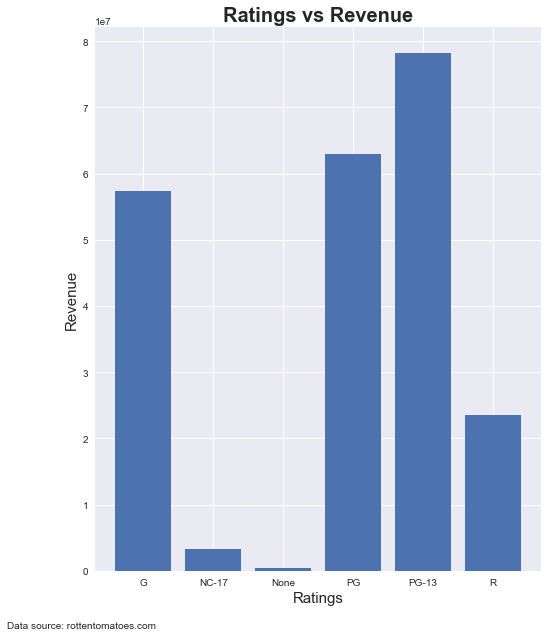

In [86]:
r_and_r_bar, ax = plt.subplots(figsize = (8,10));
x = rt.groupby(['Rating'])['Box Office (Gross USA)'].mean().index
y = rt.groupby(['Rating'])['Box Office (Gross USA)'].mean()
ax.set_title('Ratings vs Revenue', fontdict = {'size': 20, 'weight':'bold'})
ax.set_xlabel('Ratings', fontdict= {'size':15})
ax.set_ylabel('Revenue', fontdict= {'size':15});
ax.text(-.03, -.1, "Data source: rottentomatoes.com", 
        fontsize=10, horizontalalignment='center', 
        verticalalignment='center', transform=ax.transAxes)
ax.bar(x,y);

In [74]:
rt['Gross in Millions'] = rt['Box Office (Gross USA)'] / 1000000

Text(-0.03, -0.1, 'Data source: rottentomatoes.com')

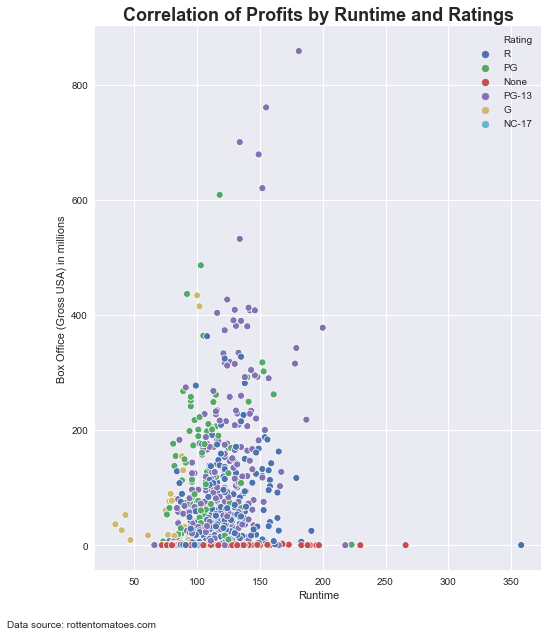

In [88]:
fig, ax = plt.subplots(figsize = (8,10))
sns.scatterplot(data = rt, x = 'Runtime', y='Gross in Millions', 
               hue = 'Rating', ax=ax)
ax.set_title('Correlation of Profits by Runtime and Ratings', fontdict={'size':18, 'weight':'bold'})
ax.set_ylabel('Box Office (Gross USA) in millions')
ax.text(-.03, -.1, "Data source: rottentomatoes.com", 
        fontsize=10, horizontalalignment='center', 
        verticalalignment='center', transform=ax.transAxes)


In [6]:
tmdb = pd.read_csv(path +'tmdb.csv', index_col=0, parse_dates=['release_date'])
pd.set_option('display.max_colwidth', -1, 'display.float_format', lambda x: '%.5f' % x)

In [12]:
tmdb['profit'] = tmdb.revenue - tmdb.budget

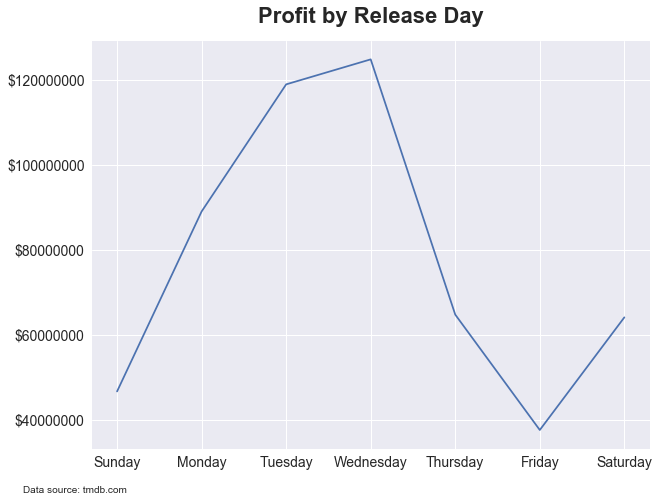

In [89]:
fig, ax = plt.subplots(figsize=(10,7.5), facecolor='white')
data = tmdb.groupby(tmdb['release_date'].dt.weekday_name).profit.mean().reindex(
    ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])

x = data.index
y = data.values

plt.style.use('seaborn')
ax.set_title('Profit by Release Day', fontsize=22, fontweight='bold' )
ax.title.set_position([.5, 1.03])

plt.ticklabel_format(style='plain')
plt.xticks(fontsize=14)    
plt.yticks(fontsize=14)    
formatter = ticker.FormatStrFormatter('$%1.0f')
ax.yaxis.set_major_formatter(formatter)

plt.text(-.03, -.1, "Data source: tmdb.com", fontsize=10, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

ax.plot(x,y)
plt.show()

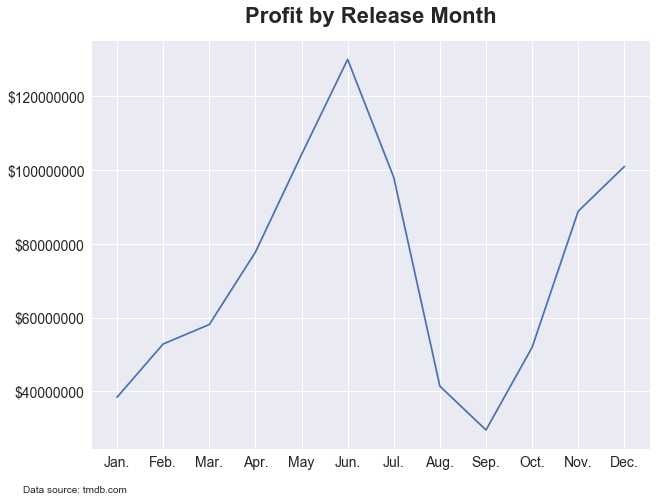

In [90]:
fig, ax = plt.subplots(figsize=(10,7.5), facecolor='white')

x = ['Jan.', 'Feb.', 'Mar.', 'Apr.', 'May', 'Jun.', 'Jul.', 'Aug.', 'Sep.', 'Oct.', 'Nov.', 'Dec.']
y = tmdb.groupby(tmdb['release_date'].dt.month).profit.mean().values

plt.style.use('seaborn')
ax.set_title('Profit by Release Month', fontsize=22, fontweight='bold')
ax.title.set_position([.5, 1.03])

plt.ticklabel_format(style='plain')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
formatter = ticker.FormatStrFormatter('$%1.0f')
ax.yaxis.set_major_formatter(formatter)

plt.text(-.03, -.1, "Data source: tmdb.com", fontsize=10, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

ax.plot(x,y)
plt.show()

In [9]:
tmdb['audience'] = tmdb['original_language'].map(lambda x : 'Domestic' if x == 'en' else 'Foreign')

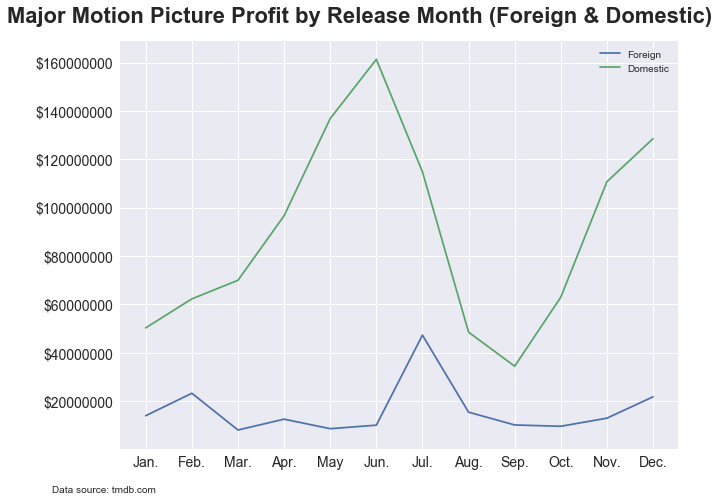

In [16]:
fig, ax = plt.subplots(figsize=(10,7.5), facecolor='white')
plt.style.use('seaborn')
plt.ticklabel_format(style='plain')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
formatter = ticker.FormatStrFormatter('$%1.0f')
ax.yaxis.set_major_formatter(formatter)

x = ['Jan.', 'Feb.', 'Mar.', 'Apr.', 'May', 'Jun.', 'Jul.', 'Aug.', 'Sep.', 'Oct.', 'Nov.', 'Dec.']
y = tmdb[tmdb['audience'] == 'Foreign'].groupby(tmdb['release_date'].dt.month).profit.mean().values
ax.set_title('Profit by Release Month', fontsize=22)
ax.plot(x,y)

x = ['Jan.', 'Feb.', 'Mar.', 'Apr.', 'May', 'Jun.', 'Jul.', 'Aug.', 'Sep.', 'Oct.', 'Nov.', 'Dec.']
y = tmdb[tmdb['audience'] == 'Domestic'].groupby(tmdb['release_date'].dt.month).profit.mean().values
ax.set_title('Major Motion Picture Profit by Release Month (Foreign & Domestic)', fontsize=22, fontweight='bold')
ax.title.set_position([.429, 1.03])
ax.plot(x,y)

plt.text(-.03, -.1, "Data source: tmdb.com", fontsize=10, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.legend(['Foreign', 'Domestic'])
plt.show()

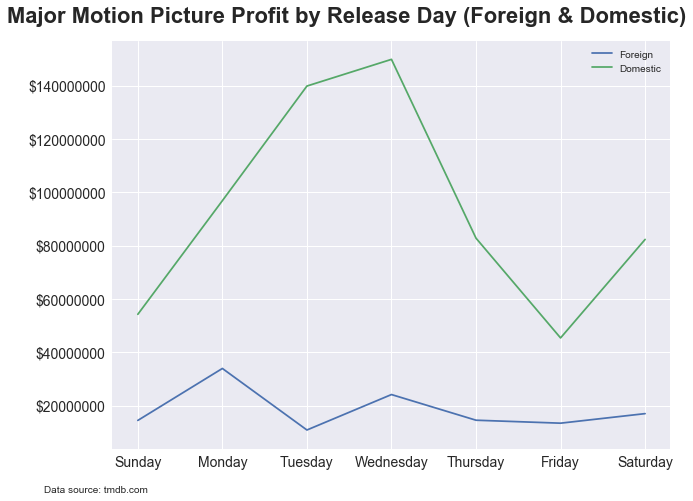

In [15]:
fig, ax = plt.subplots(figsize=(10,7.5), facecolor='white')
plt.style.use('seaborn')
plt.ticklabel_format(style='plain')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
formatter = ticker.FormatStrFormatter('$%1.0f')
ax.yaxis.set_major_formatter(formatter)

data = tmdb[tmdb['audience'] == 'Foreign'].groupby(tmdb['release_date'].dt.weekday_name).profit.mean().reindex(
    ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
x = data.index
y = data.values
ax.set_title('Profit by Release Month', fontsize=22)
ax.plot(x,y)

data = tmdb[tmdb['audience'] == 'Domestic'].groupby(tmdb['release_date'].dt.weekday_name).profit.mean().reindex(
    ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
x = data.index
y = data.values
ax.set_title('Major Motion Picture Profit by Release Day (Foreign & Domestic)', fontsize=22, fontweight='bold')
ax.title.set_position([.42, 1.03])
ax.plot(x,y)

plt.text(-.03, -.1, "Data source: tmdb.com", fontsize=10, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.legend(['Foreign', 'Domestic'])
plt.show()